In [1]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501.xlsx


In [12]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [53]:
# 금속 컬럼 추출 (Al ~ Bi)
metal_columns = df.columns[df.columns.str.endswith('(ng/m3)')]

In [54]:
# 시간 데이터로 변환 (Pump-Begin 기준)
df['Pump-Begin'] = pd.to_datetime(df['Pump-Begin'])

In [55]:
# 음수값 전처리
df[metal_columns] = df[metal_columns].applymap(lambda x: x if x >= 0 else np.nan)

/tmp/ipython-input-1341552548.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[metal_columns] = df[metal_columns].applymap(lambda x: x if x >= 0 else np.nan)


In [57]:
# 날짜 컬럼 생성 (datetime을 date로 변환)
df['Date'] = df['Pump-Begin'].dt.date

# 날짜 분할 (6일 단위)
unique_dates = sorted(df['Date'].unique())
chunks = [unique_dates[i:i+6] for i in range(0, len(unique_dates), 6)]

In [58]:
# 금속 총합 계산
df['Metal_Total'] = df[metal_columns].sum(axis=1)

In [60]:
# 금속을 총합 기준으로 정렬
metal_sums = df[metal_columns].sum().sort_values(ascending=False)  # 내림차순
metal_columns_sorted = metal_sums.index.tolist()  # 금속 컬럼 리스트 정렬

/tmp/ipython-input-3891352691.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(metal_columns_sorted))


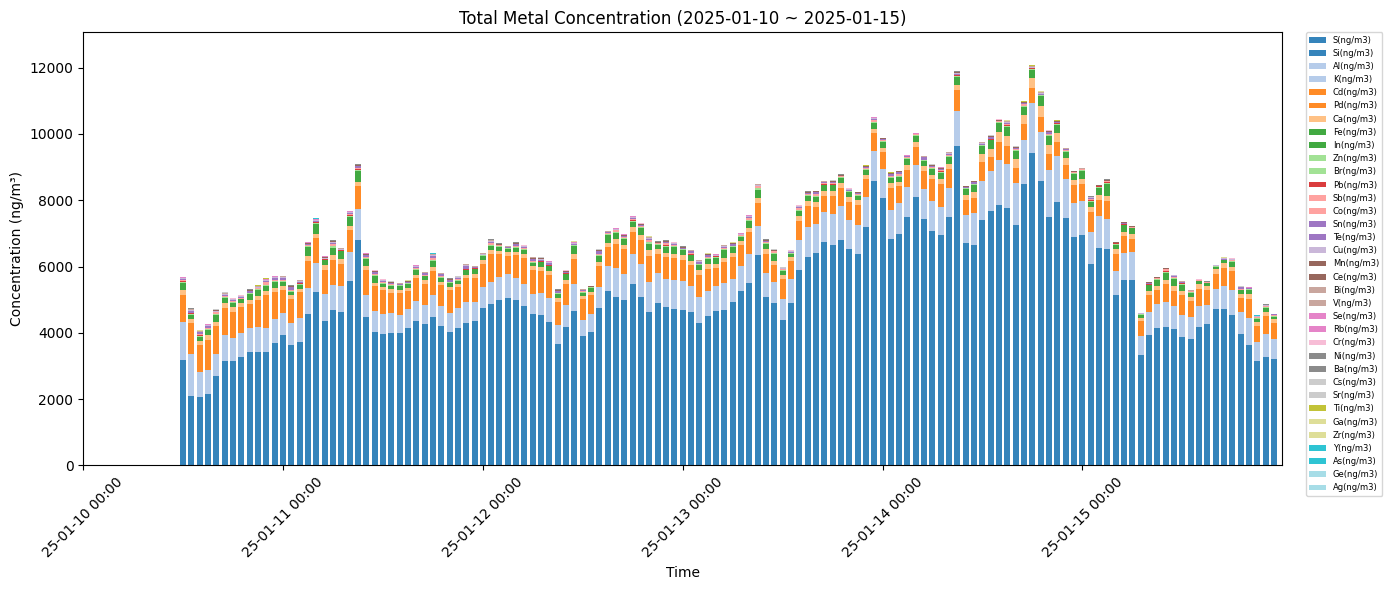

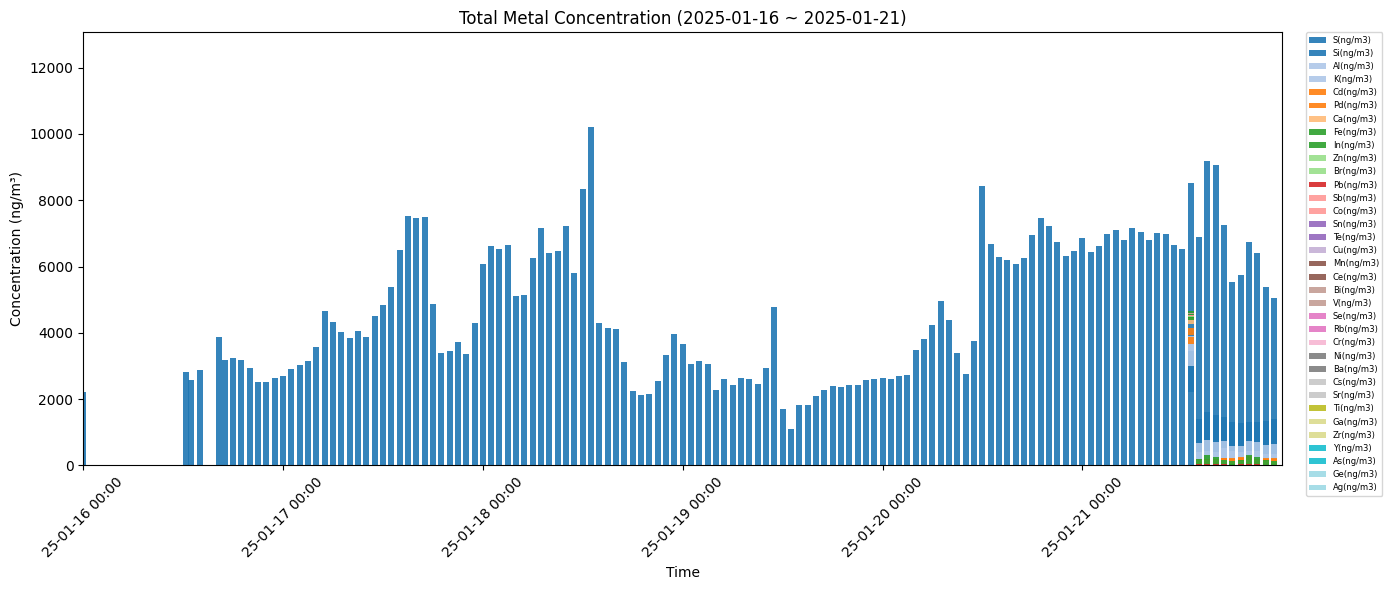

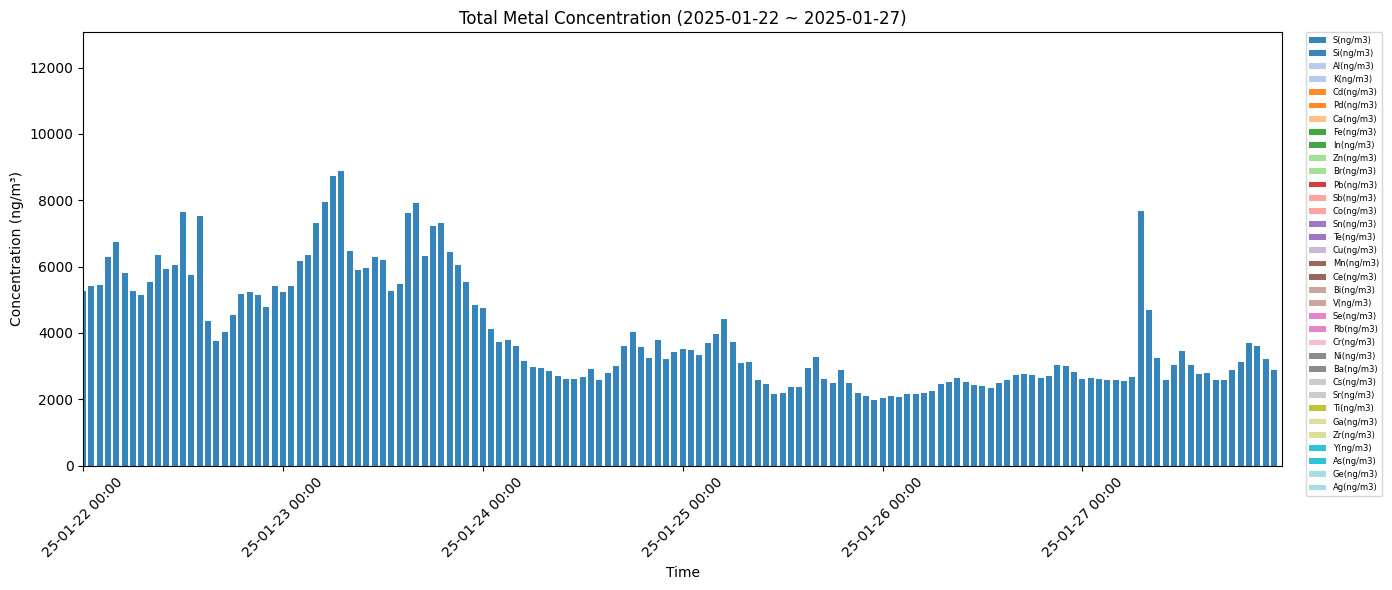

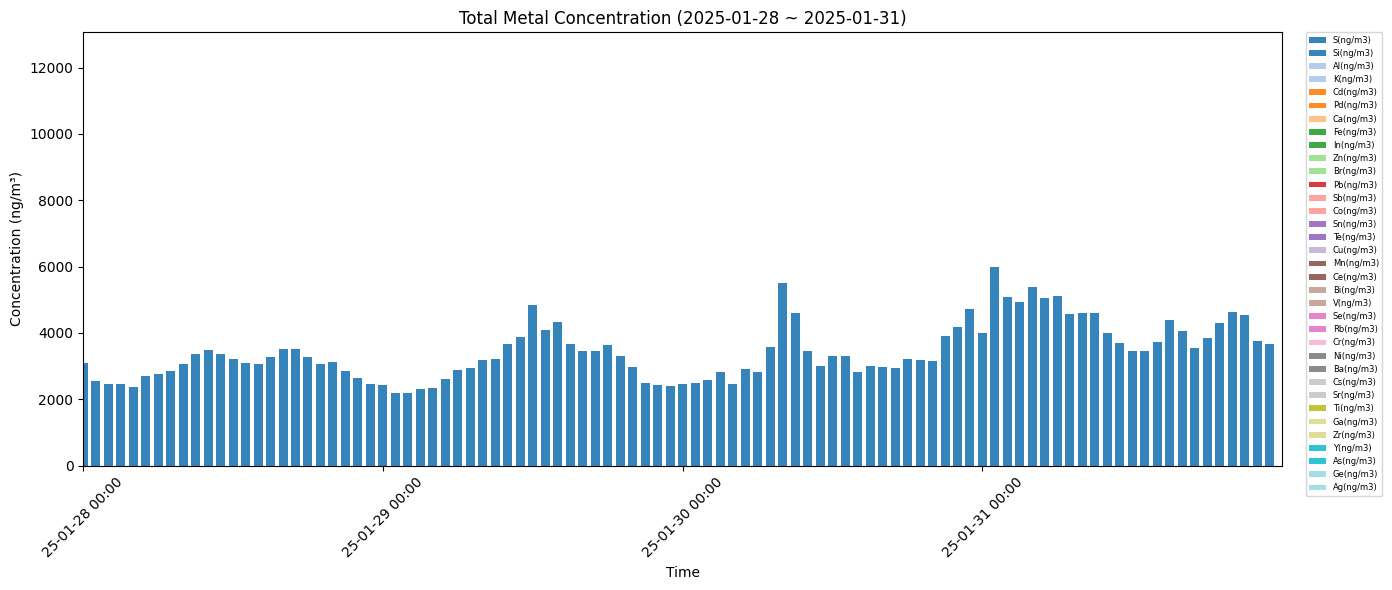

In [61]:
# 전체 데이터 기준 Y축 최대값 계산
global_ymax = np.percentile(df[metal_columns_sorted].sum(axis=1), 97) * 1.1

# 색상 팔레트 (정렬된 금속 순서에 맞춰 고정)
colors = cm.get_cmap('tab20', len(metal_columns_sorted))

# 금속 총합 누적 막대그래프 생성
for date_group in chunks:
    start_date = pd.to_datetime(min(date_group))
    end_date = pd.to_datetime(max(date_group)) + pd.Timedelta(hours=23, minutes=59)

    temp_df = df[df['Date'].isin(date_group)].copy()
    temp_df = temp_df[(temp_df['Pump-Begin'] >= start_date) & (temp_df['Pump-Begin'] <= end_date)]
    temp_df = temp_df.sort_values('Pump-Begin')

    # NaN값 0 변환 (빈칸 방지 및 색상 순서 고정)
    temp_df[metal_columns_sorted] = temp_df[metal_columns_sorted].fillna(0)

    plt.figure(figsize=(14, 6))
    bottom_values = pd.Series([0]*len(temp_df))

    bars = []   # 범례 고정
    labels = metal_columns_sorted

    # 금속 순서 및 색상 고정
    for idx, metal_col in enumerate(metal_columns_sorted):
        bar = plt.bar(temp_df['Pump-Begin'], temp_df[metal_col],
                      bottom=bottom_values, width=0.03,
                      color=colors(idx), alpha=0.9)
        bottom_values += temp_df[metal_col]
        bars.append(bar)

    # 그래프 기본 설정
    plt.title(f'Total Metal Concentration ({start_date.date()} ~ {end_date.date()})')
    plt.xlabel('Time')
    plt.ylabel('Concentration (ng/m³)')

    # x축, y축 설정
    plt.xlim(start_date, end_date)
    plt.ylim(0, global_ymax)
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
    plt.xticks(rotation=45)

    # 범례 고정 (항상 동일 순서, 동일 색상)
    plt.legend([b[0] for b in bars], labels,
               loc='upper left', bbox_to_anchor=(1.02, 1),
           fontsize=6, ncol=1, borderaxespad=0)

    # 그래프 출력
    plt.tight_layout()
    plt.show()